### **Import Training Dataset (Good Condition Polymer Nozzle)**

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/Aluminum_Good_Bad_30mins.csv")

# Bad Conditioned Nozzle
b_start_time = "2025-01-07 07:14:00+0000"
b_end_time = "2025-01-07 07:43:59+0000"
b_df = df[(df["TimeStamp"] >= b_start_time) & (df["TimeStamp"] <= b_end_time)].reset_index(drop=True)

# Bad Conditioned Nozzle
g_start_time = "2025-01-07 08:16:00+0000"
g_end_time = "2025-01-07 08:45:59+0000"
g_df = df[(df["TimeStamp"] >= g_start_time) & (df["TimeStamp"] <= g_end_time)].reset_index(drop=True)

b_df['Nozzle_Condition'] = 0
g_df['Nozzle_Condition'] = 1

print(f"Number of bad data points: {len(b_df)}")
print(f"Number of good data points: {len(g_df)}")


Number of bad data points: 1770
Number of good data points: 1784


### **Construct the LSTM Model Using PyTorch**

We construct an **LSTM-based anomaly detection model** using **PyTorch**. The model is designed to process time-series data from in-process parameters, learning patterns to predict deviations that indicate quality or maintenance issues.

---

### **LSTM Model Structure**
The model consists of the following components:

1. **LSTM Layer**  
   - Captures sequential dependencies in the time-series data.  
   - Processes input features and maintains temporal relationships.  

2. **Dropout Layer (Regularization)**  
   - Helps prevent overfitting by randomly deactivating **30%** of neurons during training.  

3. **Fully Connected (Dense) Layer**  
   - Maps LSTM outputs to the final predicted values.  
   - Reduces the feature representation to the desired output dimension.  

4. **Final Output**  
   - Extracts predictions from the last timestep of the LSTM output sequence.


In [2]:
import torch.nn as nn

class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMAnomalyDetector, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)  # 30% dropout rate

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout to LSTM output
        output = self.dense(lstm_out[:, -1, :])
        return output


### **Scale the Dataset and Convert It to Tensor**

We use **MinMaxScaler** from **scikit-learn** to scale the data between **0 and 1**. 


#### **Convert to Tensor**
After scaling, we convert the dataset into a **PyTorch tensor**, which is essential for:
- Efficient computation using GPUs
- Compatibility with PyTorch's LSTM model architecture


In [3]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Define the relevant features
pros_param = ["Chamber_Pressure", "Main_Gas_Flow", "PF2_Pressure", "PF2_Gas_Flow"]

# Assuming g_df contains the good dataset and pros_param lists the relevant features
X = g_df[pros_param].values  # Extract features
y = np.zeros(len(X))  # Assuming all data is normal (good)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Function to create time-series data
def create_time_series(data, timesteps):
    samples = []
    for i in range(len(data) - timesteps + 1):
        samples.append(data[i:i + timesteps])
    return np.array(samples)

# Define the number of timesteps
timesteps = 60

# Create time-series data for train and test sets
X_train_series = create_time_series(X_train, timesteps)
X_test_series = create_time_series(X_test, timesteps)

# Adjust labels to match the windows (if needed)
y_train_series = y_train[timesteps - 1:]
y_test_series = y_test[timesteps - 1:]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_series, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_series, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_series, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_series, dtype=torch.float32)

# Print PyTorch tensor shapes
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


Original X_train shape: (1427, 4)
Original X_test shape: (357, 4)
X_train_tensor shape: torch.Size([1368, 60, 4])
X_test_tensor shape: torch.Size([298, 60, 4])
y_train_tensor shape: torch.Size([1368])
y_test_tensor shape: torch.Size([298])


### **Train the LSTM Model that we constructed earlier**

In [4]:
# Parameters
input_dim = X_train_series.shape[2]  # Number of features
hidden_dim = 64
output_dim = input_dim
learning_rate = 0.0001
num_epochs = 50
batch_size = 32

# Model, loss function, and optimizer
model = LSTMAnomalyDetector(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

best_loss = float('inf')
patience = 5
trigger_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        # Training step
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch[:, -1, :])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            output = model(batch)
            loss = criterion(output, batch[:, -1, :])
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Check early stopping condition
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_count = 0  # Reset patience counter
        best_model = model.state_dict()  # Save the best model
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print("Early stopping triggered!")
            model.load_state_dict(best_model)  # Restore the best model
            break

### **Save the model checkpoint**

In [5]:
model_save_path = "../trained_model/lstm_polymer_anomaly.pth"
torch.save(best_model, model_save_path)
print(f"Model checkpoint saved to {model_save_path}")

In [6]:
# Load the trained model
model_save_path = "../trained_model/lstm_polymer_anomaly.pth"
model.load_state_dict(torch.load(model_save_path), weights_only=True)

C:\Users\yongz\AppData\Local\Temp\ipykernel_38604\3920164876.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

### **Using Percentile to Set the Threshold for Anomaly Detection**


In [7]:
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = torch.mean(torch.abs(X_test_tensor[:, -1, :] - reconstructed), axis=1)

# Compute thresholds for slight and heavy abnormalities
slight_abnormal_threshold = np.percentile(reconstruction_error.numpy(), 90)  # 90th percentile
heavy_abnormal_threshold = np.percentile(reconstruction_error.numpy(), 99)  # 99th percentile
print(f"Slight Abnormal Threshold: {slight_abnormal_threshold:.4f}")
print(f"Heavy Abnormal Threshold: {heavy_abnormal_threshold:.4f}")

# Identify anomalies
slight_abnormal_indices = reconstruction_error.numpy() > slight_abnormal_threshold
heavy_abnormal_indices = reconstruction_error.numpy() > heavy_abnormal_threshold



Slight Abnormal Threshold: 0.1609
Heavy Abnormal Threshold: 0.2111


### **Anomaly Detection on Unseen Dataset**

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def analyze_spray_data(df, start_time, end_time, spray_start_time, spray_end_time, model, scaler, pros_param, timesteps, slight_abnormal_threshold, heavy_abnormal_threshold, nozzle_condition):
    """
    Analyze spray data, detect anomalies, and plot results.

    Parameters:
    - df (DataFrame): Input DataFrame containing the time series data.
    - start_time (str): Start time for filtering the dataset.
    - end_time (str): End time for filtering the dataset.
    - spray_start_time (str): Start time of the spray process.
    - spray_end_time (str): End time of the spray process.
    - model: Pre-trained PyTorch model for anomaly detection.
    - scaler: Scaler used to normalize the features.
    - pros_param (list): List of feature column names to analyze.
    - timesteps (int): Number of timesteps for the time-series window.
    - slight_abnormal_threshold (float): Threshold for slight abnormalities.
    - heavy_abnormal_threshold (float): Threshold for heavy abnormalities.

    Returns:
    None
    """

    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format="%Y%m%dT%H:%M:%S.%f")

    # Convert string times to datetime
    start_time = pd.to_datetime(start_time, format="%Y%m%dT%H:%M:%S.%f")
    end_time = pd.to_datetime(end_time, format="%Y%m%dT%H:%M:%S.%f")
    spray_start_time = pd.to_datetime(spray_start_time, format="%Y%m%dT%H:%M:%S.%f")
    spray_end_time = pd.to_datetime(spray_end_time, format="%Y%m%dT%H:%M:%S.%f")

    # Filter the DataFrame to the defined time range
    df = df[(df['TimeStamp'] >= start_time) & (df['TimeStamp'] <= end_time)].reset_index(drop=True)
    spray_df = df[(df['TimeStamp'] >= spray_start_time) & (df['TimeStamp'] <= spray_end_time)].reset_index(drop=True)

    # Extract relevant features
    X_unseen = df[pros_param].values  # Extract features
    X_unseen_spray = spray_df[pros_param].values
    scaler = MinMaxScaler()
    X_unseen_scalar = scaler.fit(X_unseen_spray)
    X_unseen = X_unseen_scalar.transform(X_unseen)  # Normalize using the fitted scaler
    X_unseen_series = create_time_series(X_unseen, timesteps)  # Convert to time-series format
    X_unseen_tensor = torch.tensor(X_unseen_series, dtype=torch.float32)

    # Maintain mapping between time-series windows and original indices
    original_indices = df.index[timesteps - 1:]

    # Inference
    model.eval()
    with torch.no_grad():
        reconstructed_new = model(X_unseen_tensor)  # Reconstruct the new data
        reconstruction_error_new = torch.mean(torch.abs(X_unseen_tensor[:, -1, :] - reconstructed_new), axis=1)

    # Detect anomalies
    slight_abnormal_indices = reconstruction_error_new.numpy() > slight_abnormal_threshold
    heavy_abnormal_indices = reconstruction_error_new.numpy() > heavy_abnormal_threshold

    # Map indices back to the original DataFrame
    slight_abnormal_original = original_indices[slight_abnormal_indices]
    heavy_abnormal_original = original_indices[heavy_abnormal_indices]

    # Initialize the 'Label' column as 'Not Evaluated'
    df['Label'] = 'Not Evaluated'

    # Set 'Label' to 'Normal' starting from the timesteps index onwards
    df.loc[timesteps:, 'Label'] = 'Normal'

    # Update labels for slight and heavy abnormalities
    df.loc[slight_abnormal_original, 'Label'] = 'Slight Abnormal'
    df.loc[heavy_abnormal_original, 'Label'] = 'Heavy Abnormal'

    # Count abnormalities within spray start and end times
    spray_data = df[(df['TimeStamp'] >= spray_start_time) & (df['TimeStamp'] <= spray_end_time)]
    normal_count = spray_data[spray_data['Label'] == 'Normal'].shape[0]
    slight_abnormal_count = spray_data[spray_data['Label'] == 'Slight Abnormal'].shape[0]
    heavy_abnormal_count = spray_data[spray_data['Label'] == 'Heavy Abnormal'].shape[0]

    total_data = normal_count + slight_abnormal_count + heavy_abnormal_count

    print(f"Normal Count within Spray Time: {normal_count}")
    print(f"Slight Abnormal Count within Spray Time: {slight_abnormal_count}")
    print(f"Heavy Abnormal Count within Spray Time: {heavy_abnormal_count}")
    
    # Plot the features with abnormalities highlighted
    plt.figure(figsize=(14, 20))

    for i, feature in enumerate(pros_param):
        plt.subplot(len(pros_param), 1, i + 1)
        plt.plot(df['TimeStamp'], df[feature], label=feature, linewidth=0.7, color='grey', zorder=0)

        # Normal data
        normal_data = df[df['Label'] == 'Normal']
        plt.scatter(normal_data['TimeStamp'], normal_data[feature],
                    color='green', label=f'Normal (N={normal_count}, {(normal_count/total_data)*100:.1f}%))', marker='o', s=20)

        # Slight Abnormal
        slight_abnormal_data = df[df['Label'] == 'Slight Abnormal']
        plt.scatter(slight_abnormal_data['TimeStamp'], slight_abnormal_data[feature],
                    color='orange', label=f'Slight Abnormal (N={slight_abnormal_count}, {(slight_abnormal_count/total_data)*100:.1f}%)', marker='x', s=10)

        # Heavy Abnormal
        heavy_abnormal_data = df[df['Label'] == 'Heavy Abnormal']
        plt.scatter(heavy_abnormal_data['TimeStamp'], heavy_abnormal_data[feature],
                    color='red', label=f'Heavy Abnormal (N={heavy_abnormal_count}, {(heavy_abnormal_count/total_data)*100:.1f}%))', marker='x', s=10)

        # Add vertical lines for spray start and end times
        plt.axvline(spray_start_time, color='black', linestyle='--', linewidth=1.2)
        plt.axvline(spray_end_time, color='black', linestyle='--', linewidth=1.2)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5)) 
        plt.title(f"{feature} of {nozzle_condition} Nozzle", fontsize=14)
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return spray_data


Normal Count within Spray Time: 890
Slight Abnormal Count within Spray Time: 330
Heavy Abnormal Count within Spray Time: 57


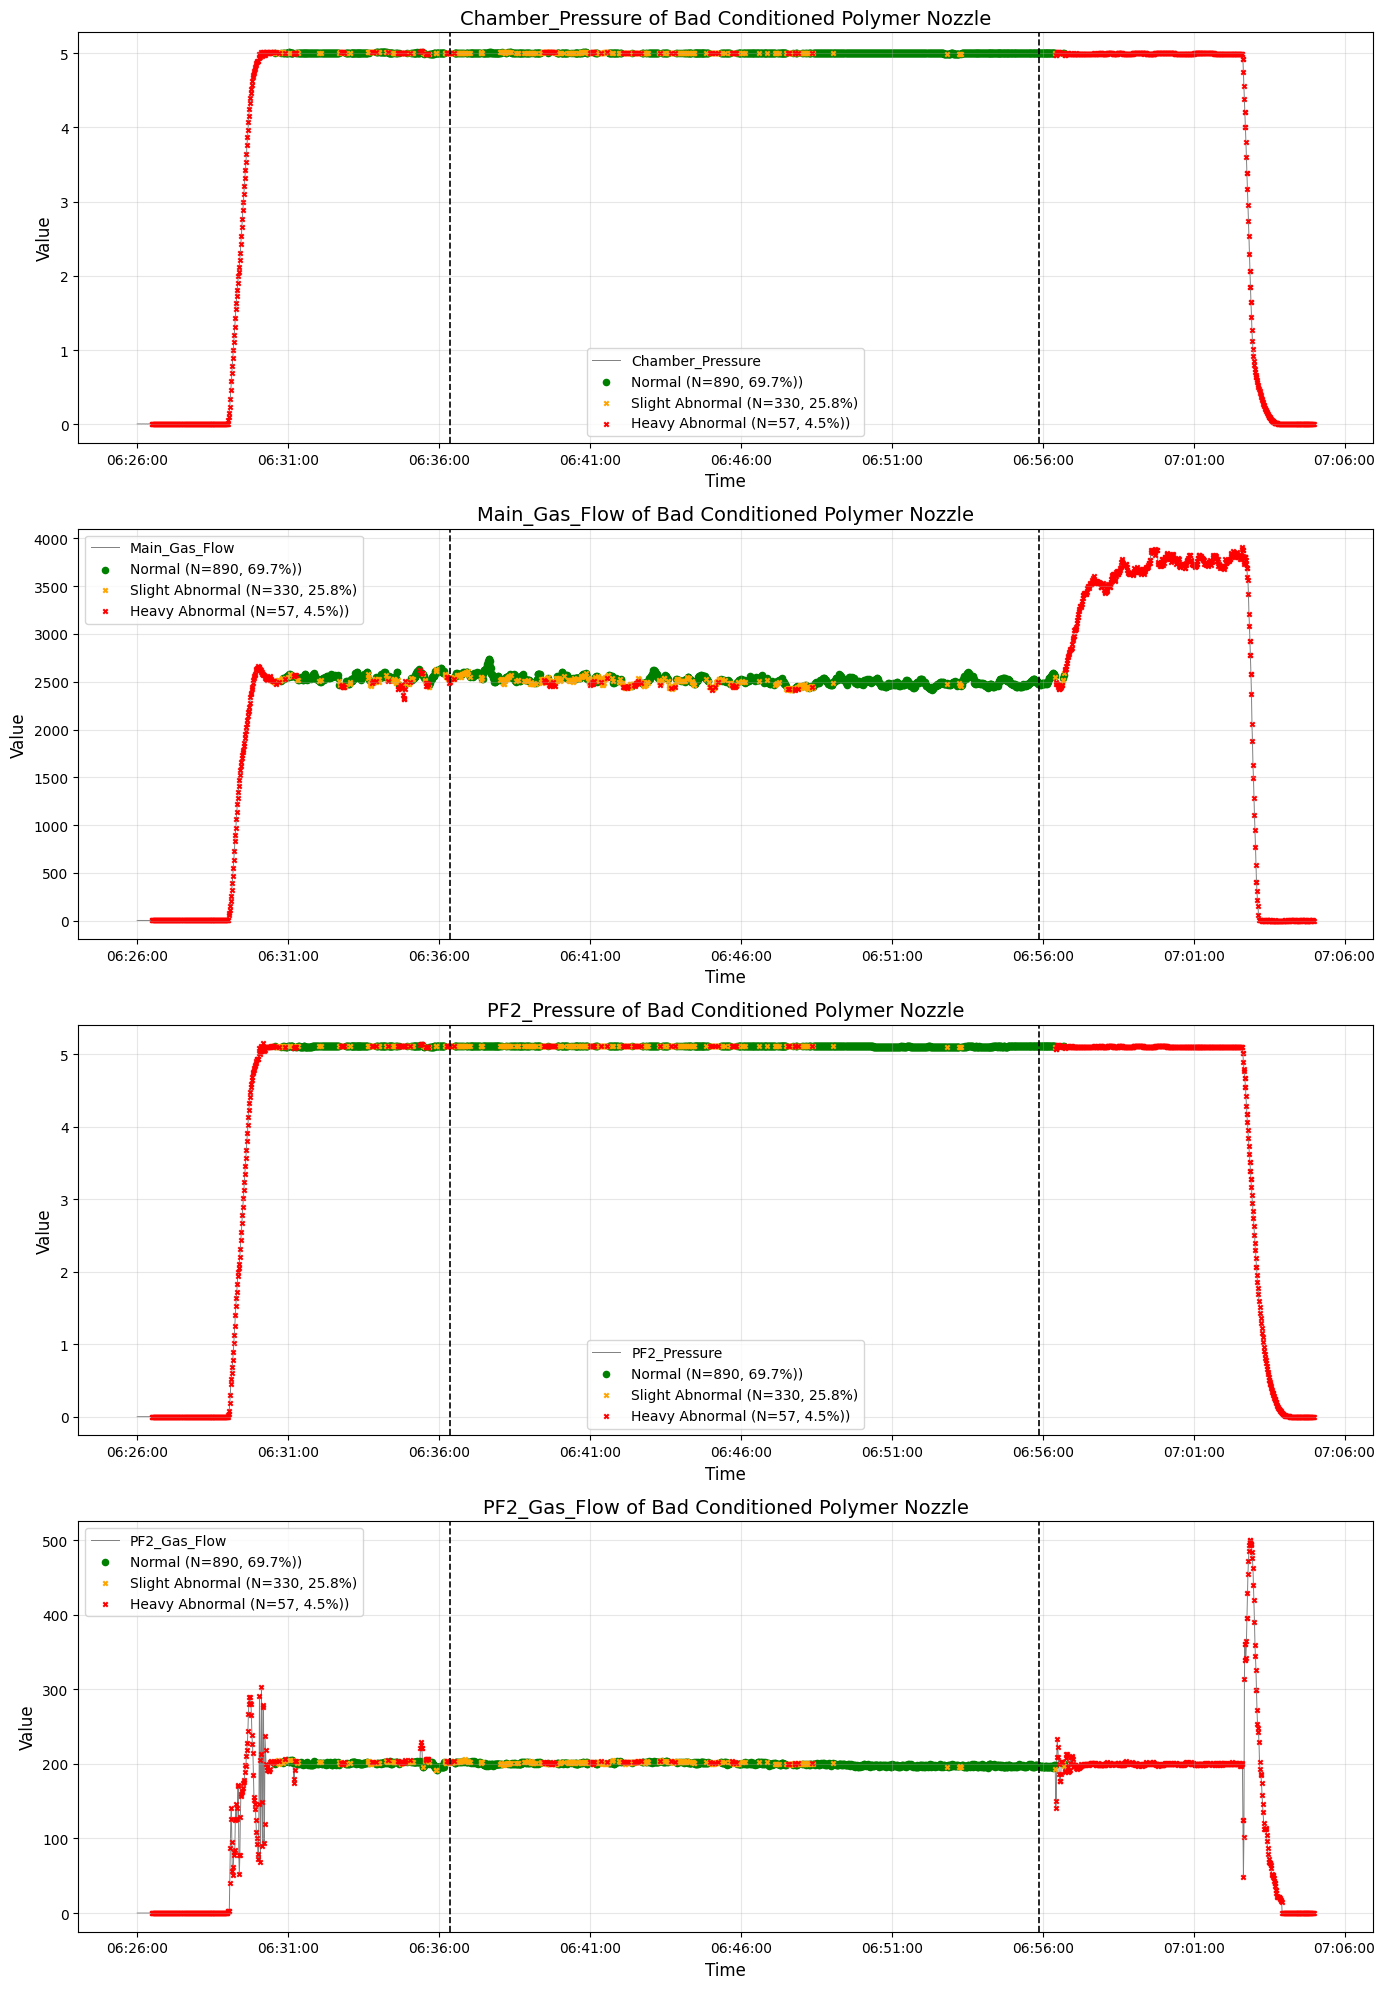

In [13]:
# Bad Nozzle

bad_spray_data = analyze_spray_data(
    df=pd.read_csv("../data/20250108_aluminum.csv"),
    start_time="20250108T06:26:00.012",
    end_time="20250108T07:04:59.007",
    spray_start_time="20250108T06:36:22.014",
    spray_end_time="20250108T06:55:52.007",
    model=model,
    scaler=scaler,
    pros_param=["Chamber_Pressure", "Main_Gas_Flow", "PF2_Pressure", "PF2_Gas_Flow"],
    timesteps=30,
    slight_abnormal_threshold=slight_abnormal_threshold,  
    heavy_abnormal_threshold=heavy_abnormal_threshold,
    nozzle_condition="Bad Conditioned Polymer"
)


Normal Count within Spray Time: 964
Slight Abnormal Count within Spray Time: 165
Heavy Abnormal Count within Spray Time: 42


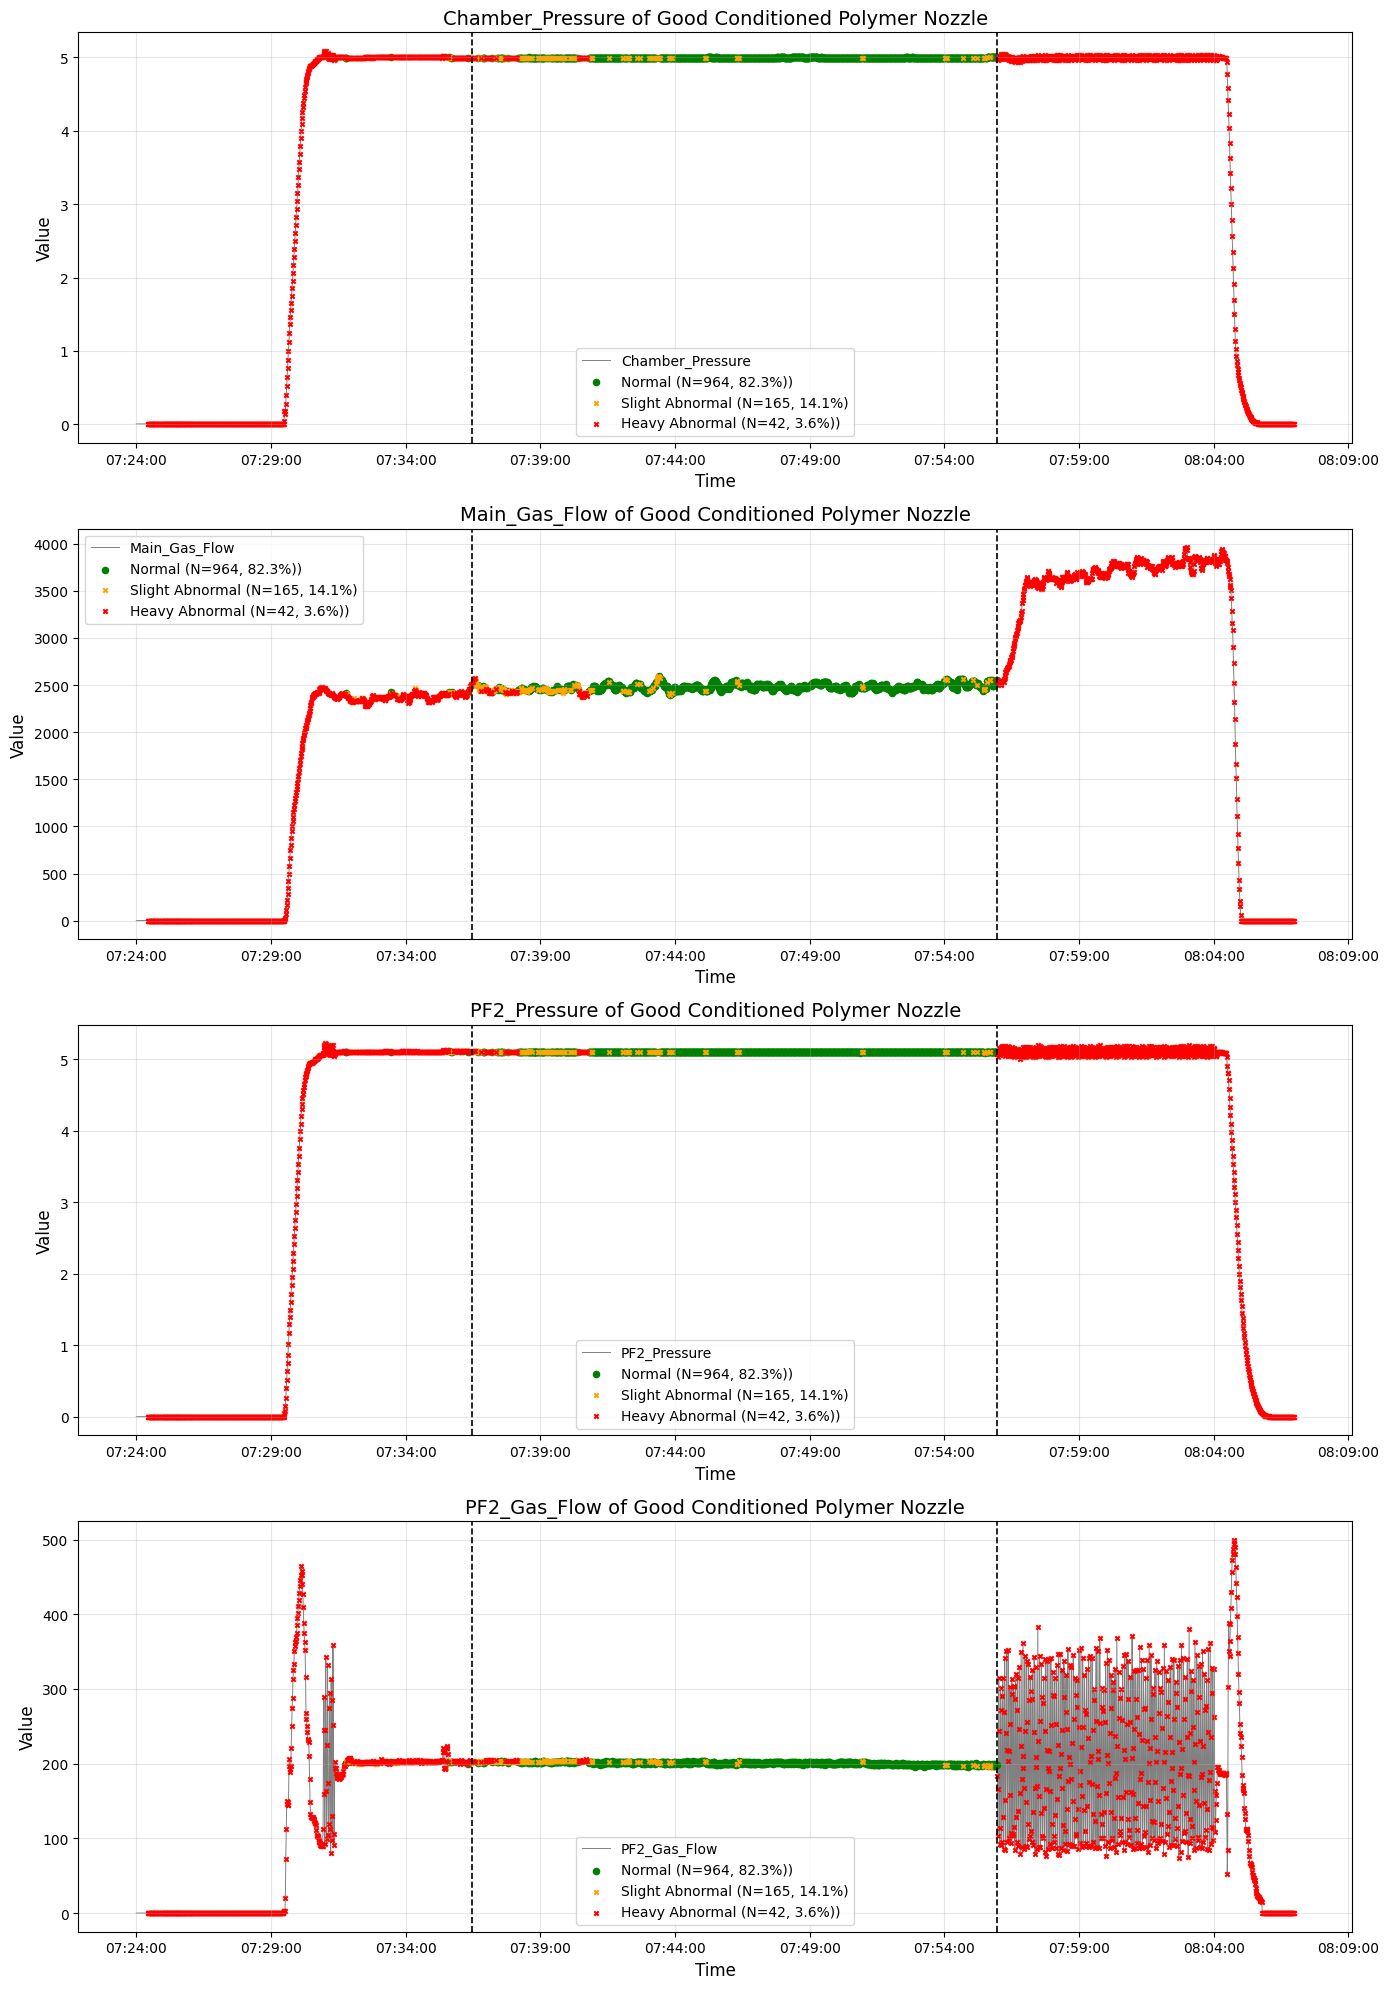

In [14]:
# Good Nozzle

good_spray_data = analyze_spray_data(
    df=pd.read_csv("../data/20250108_aluminum.csv"),
    start_time="20250108T07:24:00.013",
    end_time="20250108T08:06:59.014",
    spray_start_time="20250108T07:36:27.026",
    spray_end_time="20250108T07:55:57.005",
    model=model, 
    scaler=scaler,
    pros_param=["Chamber_Pressure", "Main_Gas_Flow", "PF2_Pressure", "PF2_Gas_Flow"],
    timesteps=30,
    slight_abnormal_threshold=slight_abnormal_threshold,  
    heavy_abnormal_threshold=heavy_abnormal_threshold,
    nozzle_condition="Good Conditioned Polymer"
)


In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_anomalies_grid(df, pros_param, title):
    """
    Visualize anomalies for each parameter in a grid.

    Parameters:
    - df: DataFrame containing the data to plot.
    - pros_param: List of parameters to plot.
    - title: Title for the plot.
    """
    # Create subplots
    num_params = len(pros_param)
    if num_params == 1:
        fig, ax = plt.subplots(figsize=(14, 6))  # Single subplot for one parameter
        axes = [ax]  # Wrap it in a list for consistent indexing
    else:
        fig, axes = plt.subplots(num_params, 1, figsize=(14, num_params * 6))  # Multiple subplots

    for i, param in enumerate(pros_param):
        ax = axes[i] if num_params > 1 else axes[0]  # Handle single or multiple subplots
        normal_data = df[df['Label'] == 'Normal']
        slight_anomalies = df[df['Label'] == 'Slight Abnormal']
        heavy_anomalies = df[df['Label'] == 'Heavy Abnormal']

        total_count = len(normal_data) + len(slight_anomalies) + len(heavy_anomalies)

        # Plot data
        ax.plot(df['TimeStamp'], df[param], linewidth=0.7, color='grey', zorder=0, label=pros_param[i])
        ax.scatter(normal_data['TimeStamp'], normal_data[param], color='green', label=f'Normal (N={len(normal_data)}, {(len(normal_data)/total_count)*100:.1f}%)', marker='.')
        ax.scatter(slight_anomalies['TimeStamp'], slight_anomalies[param], color='orange', label=f'Slight Anomaly (N={len(slight_anomalies)}, {(len(slight_anomalies)/total_count)*100:.1f}%)', marker='x')
        ax.scatter(heavy_anomalies['TimeStamp'], heavy_anomalies[param], color='red', label=f'Heavy Abnormal (N={len(heavy_anomalies)}, {(len(heavy_anomalies)/total_count)*100:.1f}%)', marker='x')

        # Add vertical lines for start and end times
        ax.axvline(df['TimeStamp'].iloc[0], color='black', linestyle='--', linewidth=1.2)
        ax.axvline(df['TimeStamp'].iloc[-1], color='black', linestyle='--', linewidth=1.2)

        # Set x-axis formatting
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

        # Set titles, labels, and limits
        ax.set_title(f'{param} of {title}', fontsize=18)
        ax.set_xlabel('Time Stamp', fontsize=14)
        ax.set_ylabel(param, fontsize=14)
        ax.set_ylim((2300, 2800))  # Adjust y-axis range if needed
        # ax.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


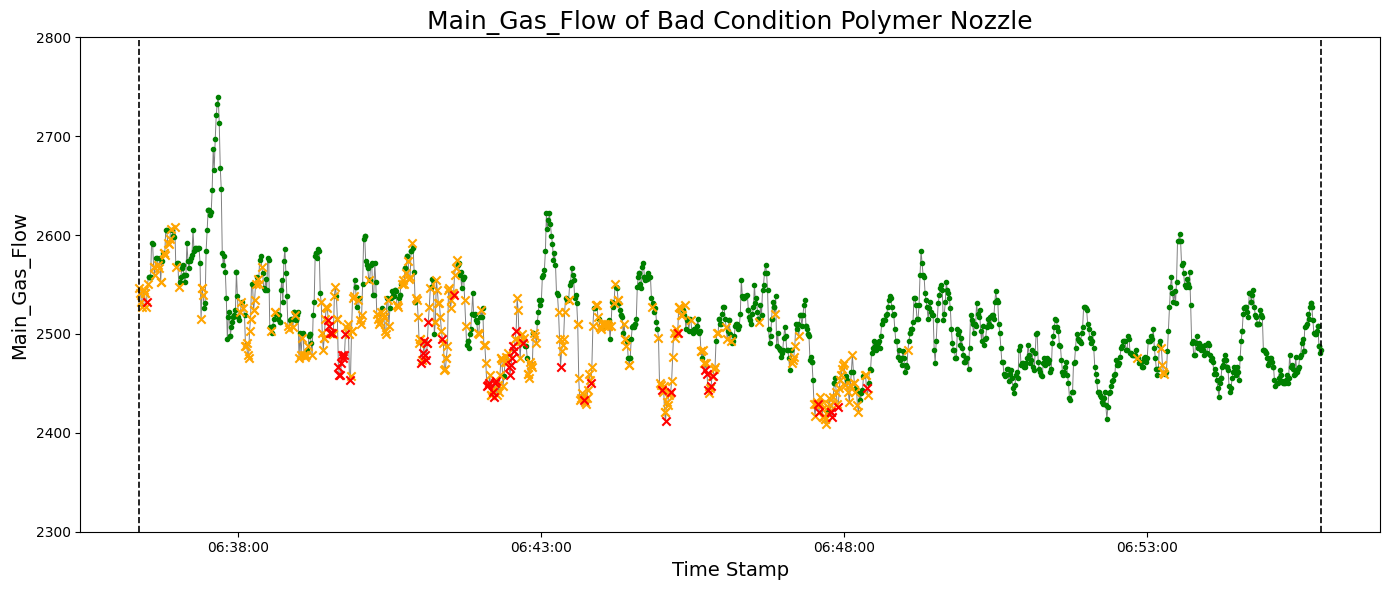

In [57]:
pros_param = ["Main_Gas_Flow"]
title = "Bad Condition Polymer Nozzle"

# Call the function to plot the anomalies
plot_anomalies_grid(bad_spray_data, pros_param, title)

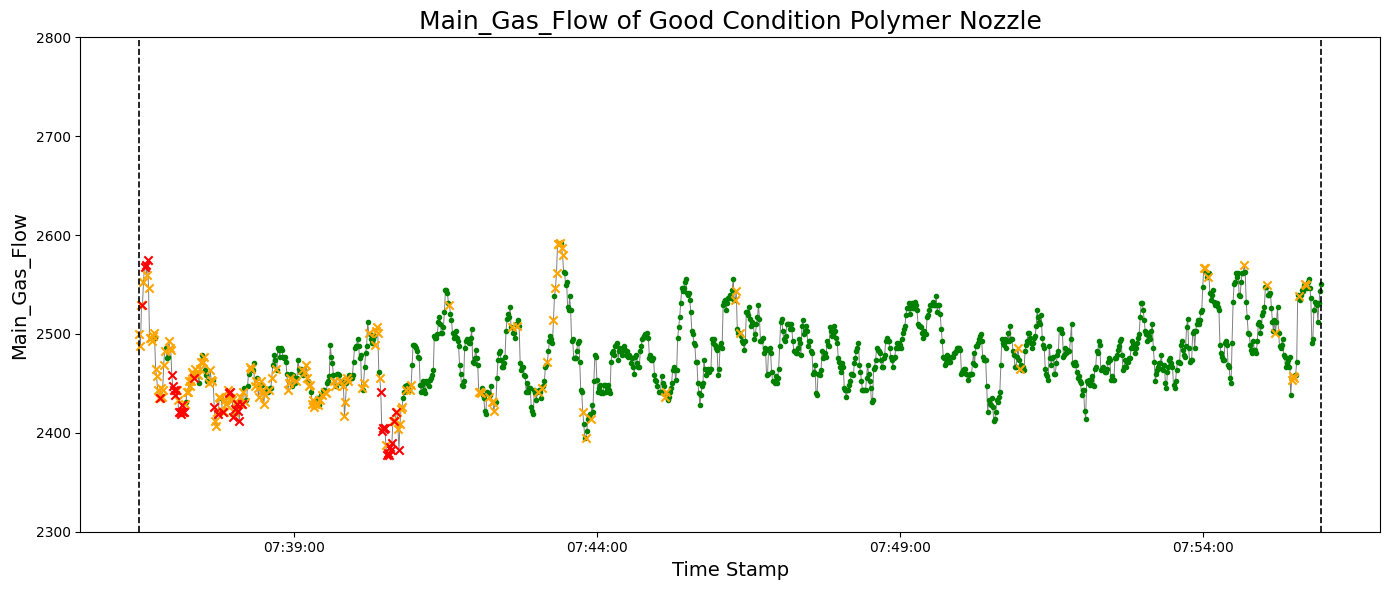

In [58]:
pros_param = ["Main_Gas_Flow"]
title = "Good Condition Polymer Nozzle"

# Call the function to plot the anomalies
plot_anomalies_grid(good_spray_data, pros_param, title)